In [1]:
# import dependencies
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import tensorflow as tf

# models
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#  Import and read the train.csv and test.csv
pax_df = pd.read_csv("./titanic3.csv")

In [2]:
# review the DataFrames
pax_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


In [3]:
# review the DataFrames
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.4+ KB


In [4]:
# Determine the number of unique values in each column.
survived_df = pax_df['survived'].value_counts()
survived_df

survived
0.0    809
1.0    500
Name: count, dtype: int64

## Preprocessing

In [5]:
# Determine the number of unique values in each column.
embarked_count = pax_df['embarked'].value_counts()
embarked_count

embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [6]:
# replacing the missing values in  
# the Embarked feature with S 
pax_df = pax_df.fillna({"embarked": "S"}) 

In [7]:
# Drop the Cabin and Ticket fature
pax_df = pax_df.drop(columns = ['cabin', 'ticket', 'boat', 'body', 'home.dest'], axis=1)

In [8]:
pax_df['fare'] = pax_df['fare'].fillna(0)

In [9]:
# Extract title
pax_df['title'] = pax_df.name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(pax_df['title'], pax_df['sex'])

sex,female,male
title,,
Capt,0,1
Col,0,4
Countess,1,0
Don,0,1
Dona,1,0
Dr,1,7
Jonkheer,0,1
Lady,1,0
Major,0,2


In [10]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1046 non-null   float64
 5   sibsp     1309 non-null   float64
 6   parch     1309 non-null   float64
 7   fare      1310 non-null   float64
 8   embarked  1310 non-null   object 
 9   title     1309 non-null   object 
dtypes: float64(6), object(4)
memory usage: 102.5+ KB


In [11]:
# replace various titles with more common names
pax_df['title'] = pax_df['title'].replace(['Lady', 'Capt', 'Col', 
                                                 'Don', 'Dr', 'Major', 
                                                 'Rev', 'Jonkheer', 'Dona'], 
                                                'Rare') 
  
pax_df['title'] = pax_df['title'].replace( 
        ['Countess', 'Lady', 'Sir'], 'Royal')

pax_df['title'] = pax_df['title'].replace('Mlle', 'Miss') 

pax_df['title'] = pax_df['title'].replace('Ms', 'Miss') 

pax_df['title'] = pax_df['title'].replace('Mme', 'Mrs') 
    
pax_df[['title', 'survived']].groupby(['title'], as_index=False).mean() 

,title,survived
0,Master,0.508197
1,Miss,0.678030
2,Mr,0.162483
3,Mrs,0.787879
4,Rare,0.333333
5,Royal,1.000000


In [12]:
# map each of the title groups to a numerical value 
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, 
                 "Master": 4, "Royal": 5, "Rare": 6} 
pax_df['title'] = pax_df['title'].map(title_mapping)

In [13]:
#Create Embarked feature categories
ports = {"S": 0, "C": 1, "Q": 2}
pax_df['embarked'] = pax_df['embarked'].map(ports)

In [14]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1046 non-null   float64
 5   sibsp     1309 non-null   float64
 6   parch     1309 non-null   float64
 7   fare      1310 non-null   float64
 8   embarked  1310 non-null   int64  
 9   title     1309 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 102.5+ KB


In [15]:
# sort the ages into logical categories 
pax_df["age"] = pax_df["age"].fillna(-0.5) 
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf] 
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 
          'Young Adult', 'Middle Adult', 'Older Adult', 'Senior'] 
pax_df['AgeGroup'] = pd.cut(pax_df["age"], bins, labels=labels) 

In [16]:
pax_df[['AgeGroup', 'survived']].groupby(['AgeGroup'], as_index=False).mean() 

C:\Users\mmmar\AppData\Local\Temp\ipykernel_18276\2090154.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pax_df[['AgeGroup', 'survived']].groupby(['AgeGroup'], as_index=False).mean()


,AgeGroup,survived
0,Unknown,0.277567
1,Baby,0.660714
2,Child,0.447368
3,Teenager,0.414141
4,Young Adult,0.381395
5,Middle Adult,0.389241
6,Older Adult,0.411765
7,Senior,0.242424


In [17]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   survived  1309 non-null   float64 
 2   name      1309 non-null   object  
 3   sex       1309 non-null   object  
 4   age       1310 non-null   float64 
 5   sibsp     1309 non-null   float64 
 6   parch     1309 non-null   float64 
 7   fare      1310 non-null   float64 
 8   embarked  1310 non-null   int64   
 9   title     1309 non-null   float64 
 10  AgeGroup  1310 non-null   category
dtypes: category(1), float64(7), int64(1), object(2)
memory usage: 104.1+ KB


In [18]:
# Use the title information to fill in the missing agegroup values.
mr_age = pax_df[pax_df["title"] == 1]["AgeGroup"].mode()  # Middle Adult 
miss_age = pax_df[pax_df["title"] == 2]["AgeGroup"].mode()  # Young Adult 
mrs_age = pax_df[pax_df["title"] == 3]["AgeGroup"].mode()  # Older Adult 
master_age = pax_df[pax_df["title"] == 4]["AgeGroup"].mode()  # Baby 
royal_age = pax_df[pax_df["title"] == 5]["AgeGroup"].mode()  # Older Adult 
rare_age = pax_df[pax_df["title"] == 6]["AgeGroup"].mode()  # Older Adult 
  
age_title_mapping = {1: "Middle Adult", 2: "Young Adult", 
                     3: "Older Adult", 4: "Baby", 5: "Older Adult", 6: "Older Adult"} 
  
for x in range(len(pax_df["AgeGroup"])): 
    if pax_df["AgeGroup"][x] == "Unknown"and not pd.isnull(pax_df["title"][x]): 
       pax_df["AgeGroup"][x] = age_title_mapping[pax_df["title"][x]] 

In [19]:
# drop the non-beneficial ID columns "Name"
pax_df= pax_df.drop(['name'], axis=1) 

In [20]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   pclass    1309 non-null   float64 
 1   survived  1309 non-null   float64 
 2   sex       1309 non-null   object  
 3   age       1310 non-null   float64 
 4   sibsp     1309 non-null   float64 
 5   parch     1309 non-null   float64 
 6   fare      1310 non-null   float64 
 7   embarked  1310 non-null   int64   
 8   title     1309 non-null   float64 
 9   AgeGroup  1310 non-null   category
dtypes: category(1), float64(7), int64(1), object(1)
memory usage: 93.9+ KB


In [21]:
# Assigning numerical values to sex
sex_mapping = {"male": 0, "female": 1} 
pax_df['sex'] = pax_df['sex'].map(sex_mapping) 

In [22]:
pax_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,AgeGroup
0,1.0,1.0,1.0,29.0000,0.0,0.0,211.3375,0,2.0,Middle Adult
1,1.0,1.0,0.0,0.9167,1.0,2.0,151.5500,0,4.0,Baby
2,1.0,0.0,1.0,2.0000,1.0,2.0,151.5500,0,2.0,Baby
3,1.0,0.0,0.0,30.0000,1.0,2.0,151.5500,0,1.0,Middle Adult
4,1.0,0.0,1.0,25.0000,1.0,2.0,151.5500,0,3.0,Middle Adult


In [23]:
# map each Age value to a numerical value 
age_mapping = {'Unknown': 0, 'Baby': 1, 'Child': 2, 'Teenager': 4, 
               'Young Adult': 5, 'Middle Adult': 6, 'Older Adult': 7,
               'Senior': 8} 
pax_df['AgeGroup'] = pax_df['AgeGroup'].map(age_mapping) 

pax_df.head() 

,pclass,survived,sex,age,sibsp,parch,fare,embarked,title,AgeGroup
0,1.0,1.0,1.0,29.0000,0.0,0.0,211.3375,0,2.0,6
1,1.0,1.0,0.0,0.9167,1.0,2.0,151.5500,0,4.0,1
2,1.0,0.0,1.0,2.0000,1.0,2.0,151.5500,0,2.0,1
3,1.0,0.0,0.0,30.0000,1.0,2.0,151.5500,0,1.0,6
4,1.0,0.0,1.0,25.0000,1.0,2.0,151.5500,0,3.0,6


In [24]:
# drop "age" now that we have "AgeGroup" 
pax_df= pax_df.drop(['age'], axis=1) 

In [25]:
pax_df = pax_df.dropna()

In [26]:
pax_df = pax_df.astype(int)

In [27]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1309 entries, 0 to 1308
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   pclass    1309 non-null   int32
 1   survived  1309 non-null   int32
 2   sex       1309 non-null   int32
 3   sibsp     1309 non-null   int32
 4   parch     1309 non-null   int32
 5   fare      1309 non-null   int32
 6   embarked  1309 non-null   int32
 7   title     1309 non-null   int32
 8   AgeGroup  1309 non-null   int32
dtypes: int32(9)
memory usage: 56.2 KB


## Create Random Forest Model

In [28]:
clean_data = pax_df.copy()

In [29]:
# Separate the data into labels and features

# Separate the y variable, the labels
y = clean_data['survived']

# Separate the X variable, the features
X = clean_data.drop(columns = 'survived')

In [30]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state = 1
)

## Fitting the Random Forest Model

In [31]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [32]:
# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

In [33]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [34]:
# Fitting the Random Forest Model
random_forest = RandomForestClassifier(n_estimators=100)

# Fitting the model
random_forest = random_forest.fit(X_train_scaled, y_train)

In [35]:
# Make Predictions using random forest
predictions = random_forest.predict(X_test_scaled)

## Model Evaluation


In [36]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
print(cm)

[[166  29]
 [ 44  89]]


In [37]:
# Print the balanced_accuracy score of the model
balanced = balanced_accuracy_score(y_test, predictions)
print(balanced)

0.7602274918064391


In [38]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {balanced}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,166,29
Actual 1,44,89


Accuracy Score : 0.7602274918064391
Classification Report
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       195
           1       0.75      0.67      0.71       133

    accuracy                           0.78       328
   macro avg       0.77      0.76      0.76       328
weighted avg       0.78      0.78      0.77       328



In [39]:
# Visualize the features by importance
random_importances = pd.DataFrame(sorted(zip(random_forest.feature_importances_, X.columns), reverse=True))
random_importances.set_index(random_importances[1], inplace=True)
random_importances.drop(columns=1, inplace=True)
random_importances.rename(columns={0: 'Feature Importances'}, inplace=True)
sorted_importances = random_importances.sort_values(by='Feature Importances')
sorted_importances

,Feature Importances
1,
embarked,0.042161
parch,0.046690
sibsp,0.062158
pclass,0.106269
AgeGroup,0.114543
sex,0.163637
title,0.177055
fare,0.287488


<Axes: title={'center': 'Features Importances'}, ylabel='1'>

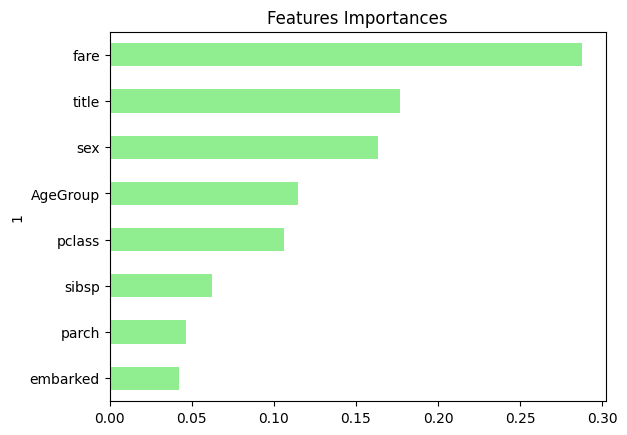

In [40]:
sorted_importances.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

## Complete Logistic Regression Model - without scaling

In [41]:
# Split the data using train_test_split again
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X,y,random_state = 1)

In [42]:
#Declare the logistic regression model
logistic_regression_model = LogisticRegression(random_state=1)

#Fit the model using the training data
lr_model_org = logistic_regression_model.fit(X_train_lr, y_train_lr)

C:\Users\mmmar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
#Generate testing predictions
predictions_org = logistic_regression_model.predict(X_test_lr)

In [44]:
#Print the balanced accuracy score of the model
balanced_accuracy_score(y_test_lr, predictions_org)

0.7997108155002892

In [45]:
cm_logistic = confusion_matrix(y_test_lr, predictions_org)
print(cm_logistic)

[[177  18]
 [ 41  92]]


In [46]:
#Print the classification report for the model
print(classification_report(y_test_lr, predictions_org))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       195
           1       0.84      0.69      0.76       133

    accuracy                           0.82       328
   macro avg       0.82      0.80      0.81       328
weighted avg       0.82      0.82      0.82       328



## Logistic Regression w/ ROS Model

In [47]:
# Import the RandomOverSampler module
from imblearn.over_sampling import RandomOverSampler

# Declare the random oversampler model, which will split the data more evenly
ros = RandomOverSampler(random_state = 1)

# Split the data using train_test_split again
x_train_ros, x_test_ros, y_train_ros, y_test_ros = train_test_split(X,y,random_state = 1)

# Fit the original training data to the random_oversampler model
x_ros, y_ros = ros.fit_resample(x_train_ros, y_train_ros)

In [48]:
# Review the balance of the y_ros variable
y_ros_df = pd.DataFrame(y_ros)
y_ros_df.value_counts()

survived
0           614
1           614
Name: count, dtype: int64

In [49]:
# Declare the Logistic Regression model
classifier_ros = LogisticRegression(random_state = 1)

# Fit the model using the resampled training data
classifier_ros.fit(x_ros,y_ros)

# Generate testing predictions
predictions_ros = classifier_ros.predict(x_test_ros)

C:\Users\mmmar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
# Print the balanced_accuracy score of the model
print(balanced_accuracy_score(y_test_ros, predictions_ros))

0.7885868517447465


In [51]:
cm_ros = confusion_matrix(y_test_ros, predictions_ros)
print(cm_ros)

[[158  37]
 [ 31 102]]


In [52]:
#Print the classification report for the model
print(classification_report(y_test_ros, predictions_ros))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82       195
           1       0.73      0.77      0.75       133

    accuracy                           0.79       328
   macro avg       0.78      0.79      0.79       328
weighted avg       0.79      0.79      0.79       328



## Logistic Regression w/ Customised Data

In [53]:
clean_data.head()

,pclass,survived,sex,sibsp,parch,fare,embarked,title,AgeGroup
0,1,1,1,0,0,211,0,2,6
1,1,1,0,1,2,151,0,4,1
2,1,0,1,1,2,151,0,2,1
3,1,0,0,1,2,151,0,1,6
4,1,0,1,1,2,151,0,3,6


In [54]:
#Create a dataframe with only the variables found in the dataframe
p_data_choice= clean_data.copy()
p_data_choice = p_data_choice[["pclass", "sex", "AgeGroup", "sibsp","parch", "survived"]]

In [55]:
p_data_choice.head()

,pclass,sex,AgeGroup,sibsp,parch,survived
0,1,1,6,0,0,1
1,1,0,1,1,2,1
2,1,1,1,1,2,0
3,1,0,6,1,2,0
4,1,1,6,1,2,0


In [56]:
#Determine the correlation between each variable and the outcome in the dataframe
c = np.corrcoef(p_data_choice['parch'], p_data_choice['survived'])
print('Correlations between age and sex\n',c)

Correlations between age and sex
 [[1.         0.08265957]
 [0.08265957 1.        ]]


In [57]:
#Seperate the data into labels and features
y_c= p_data_choice["survived"]
X_c= p_data_choice.drop(columns= "survived")

In [58]:
#Review the balance of the y variable
y_c= pd.DataFrame(y_c)
y_c.value_counts()

survived
0           809
1           500
Name: count, dtype: int64

In [59]:
# Split the data using train_test_split
# Assign a random_state of 1 to the function
x_c_train, x_c_test, y_c_train, y_c_test = train_test_split(
    X_c,
    y_c,
    random_state = 1,
    stratify = y
)

In [60]:
#Declare the logistic regression model
lr_choice_model = LogisticRegression(random_state=1)

#Fit the model using the training data
lr_choice_model.fit(x_c_train, y_c_train)

C:\Users\mmmar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:1229: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=1)

In [61]:
#Generate testing predictions
predictions_choice = lr_choice_model.predict(x_c_test)

In [62]:
#Print the balanced accuracy score of the model
balanced_accuracy_score(y_c_test, predictions_choice)

0.7587389162561576

In [63]:
cm_choice = confusion_matrix(y_c_test, predictions_choice)
print(cm_choice)

[[183  20]
 [ 48  77]]
